In [37]:
using Revise
using Pkg
using RCall
using DataFrames
using StatsBase
using CSV
R"""
library(ggplot2)
library(fitdistrplus)
library(patchwork)
library(fitdistrplus)
library(data.table)

"""
Pkg.activate("/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools")
using JuliaClusterAndTreeTools
using Statistics



  Activating project at `/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools`


In [29]:
in_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz"
output_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered.fasta.gz"
rows_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_rows.txt"
columns_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt"
keepPositionsFraction = 0.8
topNhaving_sequences_to_remove = 10

10

In [3]:
aln = JuliaClusterAndTreeTools.Alignment(in_file_name)
#aln = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz")
print("Alignment parsed")

Reading aligment /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz



Alignment parsed

In [4]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)

Doing transposition...
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...


Row,N,Gap,Total,ID,NR
,Int64,Int64,Int64,String,Int64
1,5,179,29903,England/ALDP-3C3EB7C/2022,1
2,0,179,29903,Scotland/QEUH-3C4E405/2022,2
3,0,179,29903,England/QEUH-3C5A530/2022,3
4,0,179,29903,Scotland/QEUH-3C5A7C1/2022,4
5,0,179,29903,England/ALDP-3C2902A/2022,5
6,0,194,29903,England/QEUH-3C5A8FB/2022,6
7,500,179,29903,Scotland/QEUH-3C2E7A8/2022,7
8,611,133,29903,England/PHEC-YYDU5B3/2022,8
9,3,141,29903,England/PHEC-YYDUCS7/2022,9


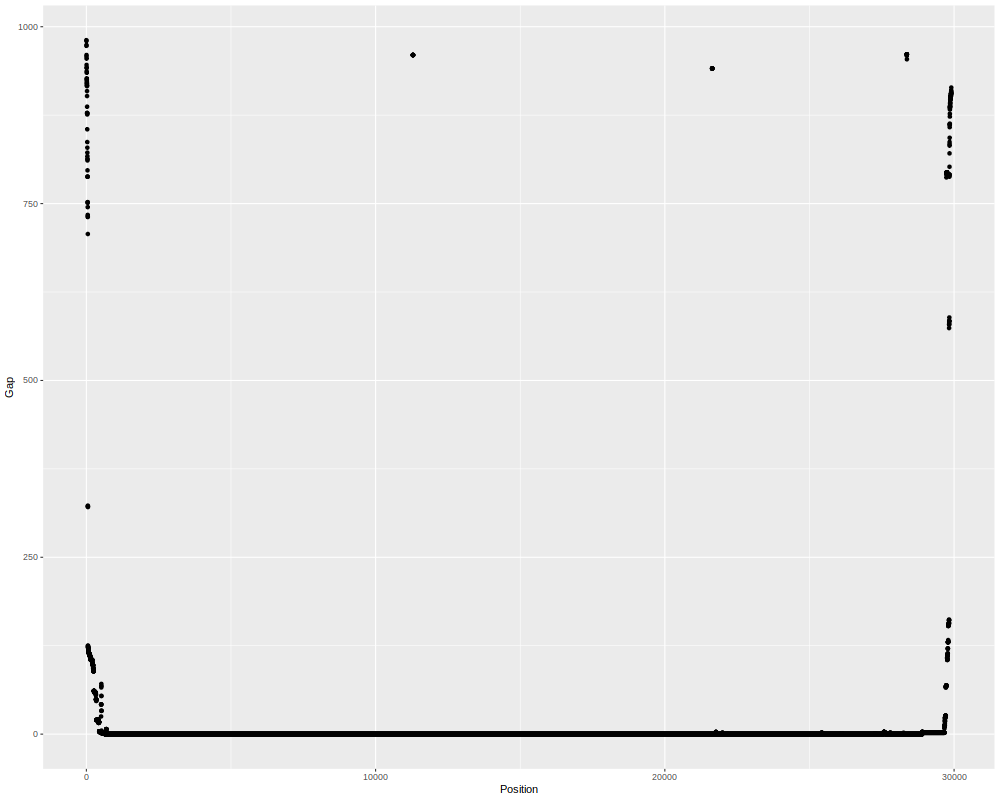

RObject{VecSxp}


In [5]:
@rput dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc) + geom_point(aes(x=Position,y=Gap))
p
"""

In [6]:
blacklist_positions = Array{Int64,1}()

Int64[]

In [7]:
# remove tails down to median value
median_Gap = median(dc.Gap)
starti = undef
endi = undef
lenAln = size(dc)[1]
for i in  1:lenAln
    if dc.Gap[i] ==0
        starti = i
        break
    else
        push!(blacklist_positions,i)
    end
end

for i in  1:lenAln
    ie = lenAln-i+1
    if dc.Gap[ie] ==0
        endi = ie
        break
    else
        push!(blacklist_positions,ie)
    end
end
println(starti)
println(endi)
#JuliaClusterAndTreeTools.sub_alignment!(aln,starti:endi)

645
28893


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


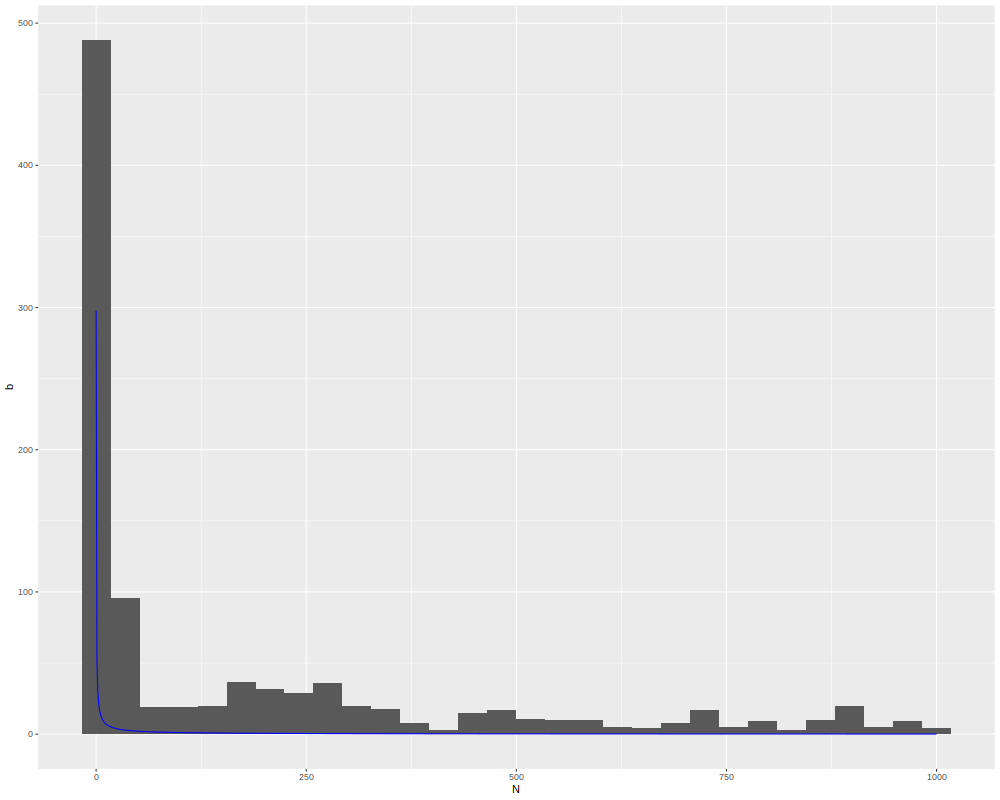

RObject{VecSxp}


In [8]:
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
fit <- fitdist(dr$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=dr) + geom_histogram(aes(x=N))
xvals <- seq(0,1000,1)#as.integer(round(dat$x),digits=1)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(dr)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""
# library(fitdistrplus)
# fit <- fitdist(dc$N, "nbinom")
# mu = as.double(fit$estimate["mu"][[1]])
# size = as.double(fit$estimate["size"][[1]])
# fitD <- dnbinom(0:60, size=size, mu=mu)

In [9]:
maxNlimit = percentile(dr.N,100-topNhaving_sequences_to_remove)
print(maxNlimit)
keep_ids = dr.ID[dr.N .< maxNlimit]
sub_alignment!(aln,keep_ids)
println(size(aln.M))
#println(maximum(dr.N))

597.6000000000013(888, 29903)


In [10]:

dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)


Doing transposition...
Done. Converting to a data frame...


Row,N,Gap,Total,ID,NR
,Int64,Int64,Int64,String,Int64
1,5,179,29903,England/ALDP-3C3EB7C/2022,1
2,0,179,29903,Scotland/QEUH-3C4E405/2022,2
3,0,179,29903,England/QEUH-3C5A530/2022,3
4,0,179,29903,Scotland/QEUH-3C5A7C1/2022,4
5,0,179,29903,England/ALDP-3C2902A/2022,5
6,0,194,29903,England/QEUH-3C5A8FB/2022,6
7,500,179,29903,Scotland/QEUH-3C2E7A8/2022,7
8,3,141,29903,England/PHEC-YYDUCS7/2022,8
9,1,179,29903,England/PHEP-YYRT8NQ/2022,9


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


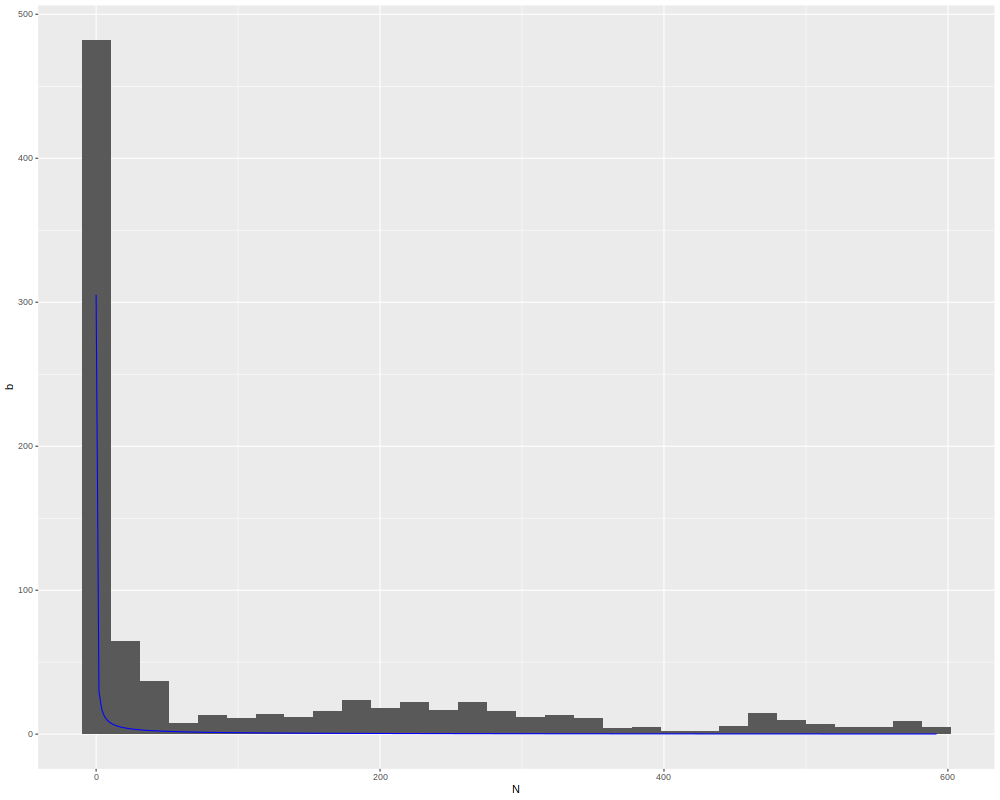

RObject{VecSxp}


In [11]:
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
df <- dr
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""

In [12]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)

Doing transposition...
Done. Converting to a data frame...
Done


Row,N,Gap,Total,Position
,Int64,Int64,Int64,Int64
1,0,882,888,1
2,1,881,888,2
3,1,875,888,3
4,0,874,888,4
5,0,862,888,5
6,0,860,888,6
7,2,858,888,7
8,1,850,888,8
9,0,847,888,9


In [13]:
dc_woterminalgaps = filter(:Position => !in(blacklist_positions), dc)

Row,N,Gap,Total,Position
,Int64,Int64,Int64,Int64
1,1,0,888,645
2,1,0,888,646
3,1,0,888,647
4,1,0,888,648
5,1,0,888,649
6,1,0,888,650
7,1,0,888,651
8,1,0,888,652
9,1,0,888,653


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


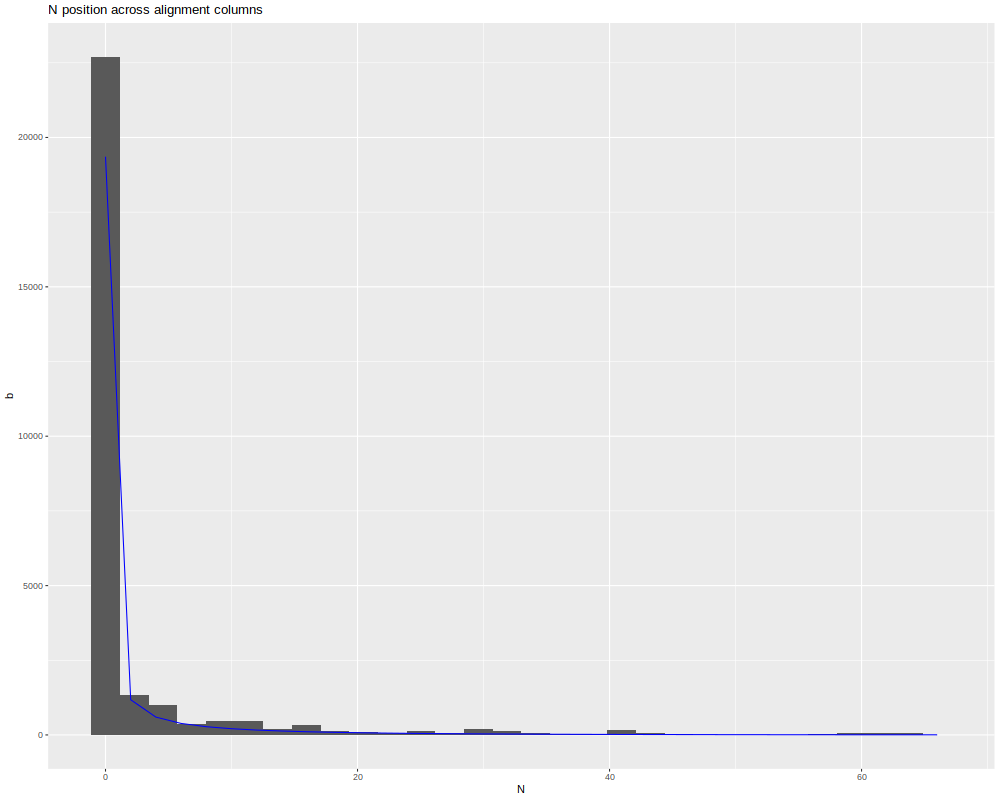

RObject{VecSxp}


In [14]:
@rput dc_woterminalgaps
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
df <- dc_woterminalgaps
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p_dc_woterminalgaps <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p_dc_woterminalgaps
"""

In [15]:
#get the limit of n to remove

@rput keepPositionsFraction dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))

R"""
fit <- fitdist(dc_woterminalgaps$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
maxNlimit = qnbinom(keepPositionsFraction, mu = mu, size = size)
"""
@rget maxNlimit
println(maxNlimit)

2.0


Distributin of N across sequence

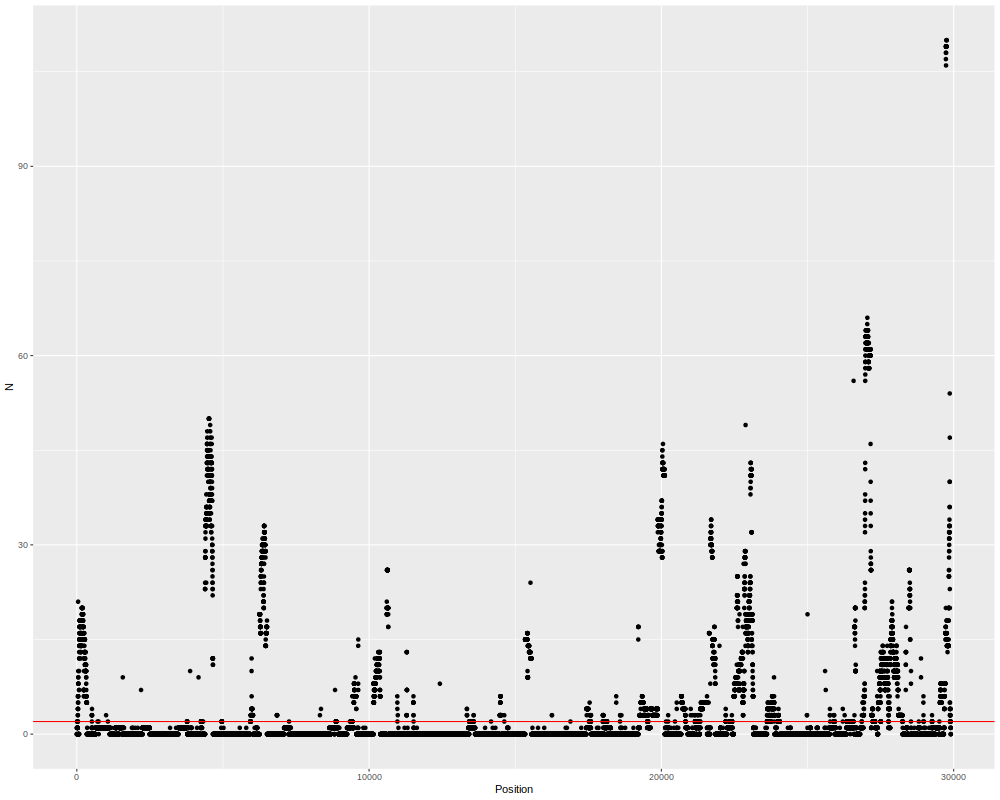

RObject{VecSxp}


In [16]:
print("Distributin of N across sequence")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
pnas <- ggplot(data=dc) + geom_point(aes(x=Position,y=N)) + geom_hline(yintercept=maxNlimit,color="red")
pnas
"""

In [17]:
dc_woterminalgaps_woN = filter(:N => <=(maxNlimit) ,dc_woterminalgaps) # 
sub_alignment_columnwise!(aln,dc_woterminalgaps_woN.Position)
#sub_alignment!(aln,dc_woterminalgaps_woN.Position)

888×23373 Matrix{BioSymbols.DNA}:
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 ⋮               

In [40]:

CSV.write(columns_after_filter, dc_woterminalgaps_woN[:,["Position"]],writeheader=false)


"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt"

In [18]:
print("Test sequence with removed high N content columns")
dc2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
@rput dc2 dr2

Doing transposition...oved high N content columnsCounted 1000 columns
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...


Row,N,Gap,Total,ID,NR
,Int64,Int64,Int64,String,Int64
1,0,0,23373,England/ALDP-3C3EB7C/2022,1
2,0,0,23373,Scotland/QEUH-3C4E405/2022,2
3,0,0,23373,England/QEUH-3C5A530/2022,3
4,0,0,23373,Scotland/QEUH-3C5A7C1/2022,4
5,0,0,23373,England/ALDP-3C2902A/2022,5
6,0,0,23373,England/QEUH-3C5A8FB/2022,6
7,0,0,23373,Scotland/QEUH-3C2E7A8/2022,7
8,0,0,23373,England/PHEC-YYDUCS7/2022,8
9,0,0,23373,England/PHEP-YYRT8NQ/2022,9


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


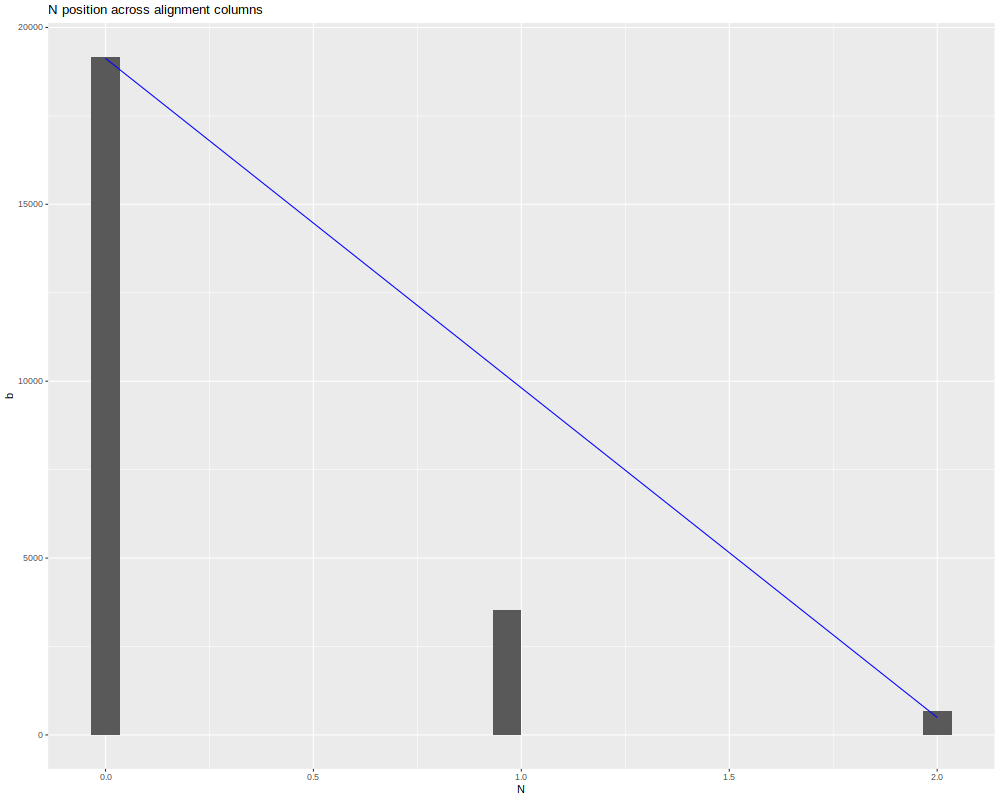

RObject{VecSxp}


In [19]:
R"""
df <- dc2
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p
"""

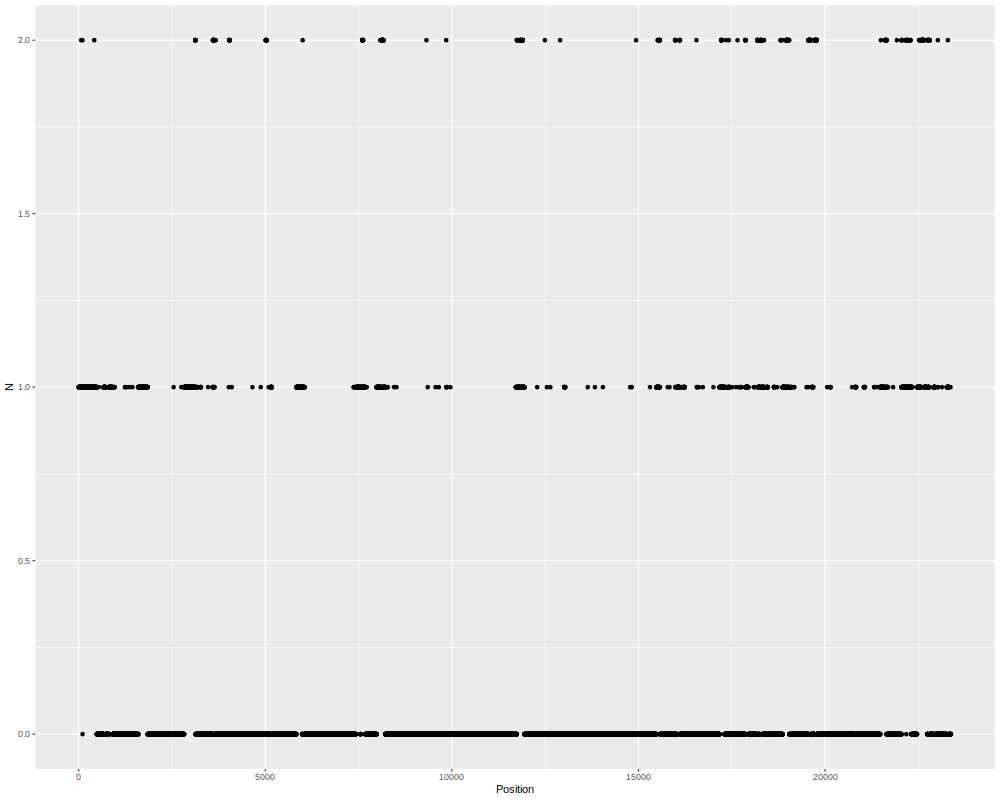

RObject{VecSxp}


In [20]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc2) + geom_point(aes(x=Position,y=N))
p
"""

┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


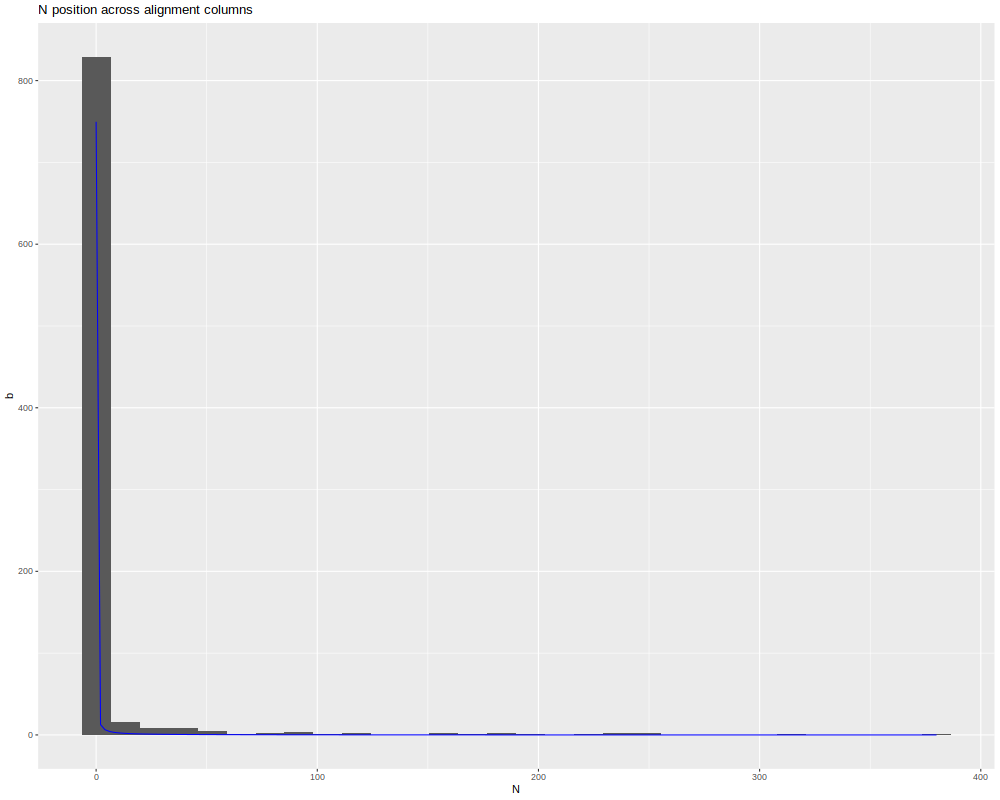

RObject{VecSxp}


In [22]:
R"""
df <- dr2
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p
"""

┌ Warning: RCall.jl: Warning: The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
│ ℹ Please use `after_stat(count)` instead.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


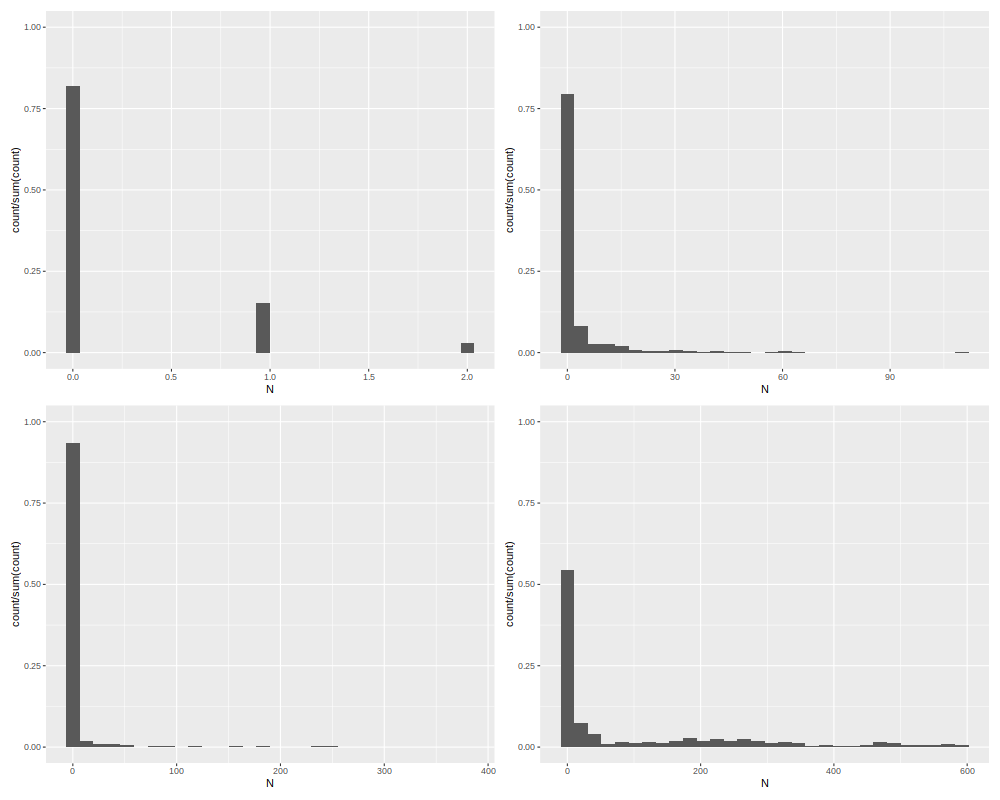

RObject{VecSxp}


In [23]:
@rput dc dc2 dr dr2
R"""
pini<-ggplot(dc, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
p<-ggplot(dc2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

pinir<-ggplot(dr, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
pr<-ggplot(dr2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

(p|pini)/(pr|pinir)
"""

In [24]:
dr2_N0 = filter(row -> row.N ==0, dr2)
print("Kept ",round(size(dr2_N0)[1]/size(dr2)[1],digits=2)," ",size(dr2_N0)[1])

Kept 0.84 747

In [43]:
#get the final set odf sequences
sub_alignment!(aln, dr2_N0.ID)

In [49]:
println(size(aln.M))
JuliaClusterAndTreeTools.write_to_fasta(aln, output_file_name)

(747, 23373)


0

In [47]:
CSV.write(rows_after_filter, dr2_N0[:,["ID"]],writeheader=false)

"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_rows.txt"

In [48]:
output_file_name

"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered.fasta.gz"

dr2_N0